In [1]:
# debug monai的导入问题
import monai

In [2]:
from ignite.engine import Events
import logging
from monai.data import NiftiSaver

In [4]:
from monai.handlers import SegmentationSaverDIY  # 自治的saver

In [5]:
# debug simpleITK的导入问题

import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
import os

In [ ]:
image_3D = sitk.Image(256, 128, 64, sitk.sitkInt16)
print(image_3D.GetDimension())

In [ ]:
test = np.ones((4,6,4))

In [ ]:
img = sitk.GetImageFromArray(test)

print(img.GetDimension())

In [ ]:
import torch

print(torch.cuda.is_available())

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_gpu_available())

In [ ]:
import torchvision
torchvision.__version__

In [6]:
# 检查itk resample的意义

import SimpleITK as sitk

def resample_sitk_image(sitk_image, spacing=None, interpolator=None, fill_value=0):
    # https://github.com/SimpleITK/SlicerSimpleFilters/blob/master/SimpleFilters/SimpleFilters.py
    _SITK_INTERPOLATOR_DICT = {
        'nearest': sitk.sitkNearestNeighbor,
        'linear': sitk.sitkLinear,
        'gaussian': sitk.sitkGaussian,
        'label_gaussian': sitk.sitkLabelGaussian,
        'bspline': sitk.sitkBSpline,
        'hamming_sinc': sitk.sitkHammingWindowedSinc,
        'cosine_windowed_sinc': sitk.sitkCosineWindowedSinc,
        'welch_windowed_sinc': sitk.sitkWelchWindowedSinc,
        'lanczos_windowed_sinc': sitk.sitkLanczosWindowedSinc
    }

    if isinstance(sitk_image, str):
        sitk_image = sitk.ReadImage(sitk_image)
    
    # Roy 从sitk拿出图像部分
    # sitk_image = sitk.GetImageFromArray(sitk_image)
    num_dim = sitk_image.GetDimension()

    if not interpolator:
        interpolator = 'linear'
        pixelid = sitk_image.GetPixelIDValue()

        if pixelid not in [1, 2, 4]:
            raise NotImplementedError(
                'Set `interpolator` manually, '
                'can only infer for 8-bit unsigned or 16, 32-bit signed integers')
        if pixelid == 1:  # 8-bit unsigned int
            interpolator = 'nearest'

    orig_pixelid = sitk_image.GetPixelIDValue()
    orig_origin = sitk_image.GetOrigin()
    orig_direction = sitk_image.GetDirection()
    orig_spacing = np.array(sitk_image.GetSpacing())
    orig_size = np.array(sitk_image.GetSize(), dtype=np.int)

    if not spacing:
        min_spacing = orig_spacing.min()
        new_spacing = [min_spacing] * num_dim
    else:
        new_spacing = [float(s) for s in spacing]

    assert interpolator in _SITK_INTERPOLATOR_DICT.keys(), \
        '`interpolator` should be one of {}'.format(_SITK_INTERPOLATOR_DICT.keys())

    sitk_interpolator = _SITK_INTERPOLATOR_DICT[interpolator]

    new_size = orig_size * (orig_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(np.int)  # Image dimensions are in integers
    new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays

    resample_filter = sitk.ResampleImageFilter()

    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetDefaultPixelValue(orig_pixelid)
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetDefaultPixelValue(fill_value)

    resampled_sitk_image = resample_filter.Execute(sitk_image)

    return resampled_sitk_image

In [8]:
# 读入nii文件

image = sitk.ReadImage('./image0.nii')
num_dim = image.GetDimension()

In [ ]:
image_after = resample_sitk_image(image, spacing=[0.5, 0.5, 0.5], interpolator='linear', fill_value=0)  # 这里的spacing是放缩，之前/之后

In [ ]:
test1 = sitk.GetArrayViewFromImage(image)  # 拿出整理之前
test2 = sitk.GetArrayViewFromImage(image_after)  # 拿出整理之后

plt.imshow(test1[99,...], cmap='gray')
plt.figure()
plt.imshow(test2[99,...], cmap='gray')

#### 检查输入的图片格式

In [ ]:
test1 = np.random.randint(0, 10, (2,2))

print(np.max(test1))

In [4]:
import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
import os

image = sitk.ReadImage('./Data_folder_norm/images/val/image0.nii')  # 整理过之后的数据
imageShow = sitk.GetArrayViewFromImage(image)
label = sitk.ReadImage('./Data_folder_norm/labels/val/label0.nii')
labelShow = sitk.GetArrayViewFromImage(label)



In [8]:
print('image range', imageShow.shape, np.max(imageShow), np.min(imageShow))
print('label range:', np.max(labelShow), np.min(labelShow))

image range (100, 100, 100) 255 0
label range: 1 0


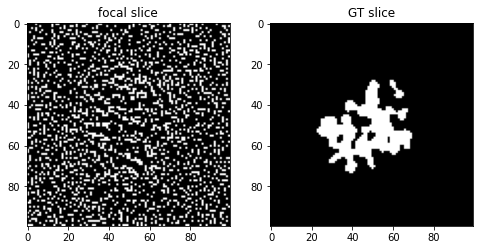

In [10]:
# visualize
import matplotlib.pyplot as plt
import random

n_slice = random.randint(0, labelShow.shape[2])

plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(imageShow[n_slice,:,:], cmap='gray')
plt.title('focal slice')
plt.subplot(122)
plt.imshow(labelShow[n_slice,:,:], cmap='gray')
plt.title('GT slice')
plt.show()

#### 读取原始文件,检查格式

In [ ]:

# Reading an animated GIF file using Python Image Processing Library - Pillow
import numpy as np
from PIL import Image
from PIL import GifImagePlugin

imageObject = Image.open("./label.gif")

print(imageObject.is_animated)
print(imageObject.n_frames)

 
stack1 = []
# Display individual frames from the loaded animated GIF file
for frame in range(0,imageObject.n_frames):
    
    imageObject.seek(frame)
    # imageObject.show()
    pix = np.array(imageObject)
    stack1.append(pix)

In [ ]:
stackNum = np.asarray(stack1)
print(np.max(stackNum), np.min(stackNum))

# testImage = stack1[0]
# print(stack1[0])
# np.max(stack1[0])

In [ ]:
import matplotlib.pyplot as plt
NUM = 80
plt.imshow(stackNum[NUM,...],cmap='gray')
print(np.max(stackNum[NUM,...]), np.min(stackNum[NUM,...]))

#### 测试monai的损失函数计算

In [ ]:
import monai 

loss_function = monai.losses.DiceCELoss(sigmoid=True)

In [ ]:
# 一个[-1,1],一个[0, 255]
testOut = np.random.randn(256, 256)
testGT = np.random.randint(0,255, (256, 256))

import torch

testDice = loss_function(torch.tensor(testOut), torch.tensor(testGT))
print(testDice.numpy())

In [ ]:
# 均为[-1, 1]
testOut = np.random.randn(256, 256)
testGT = np.random.randn(256, 256)
# testGT = np.random.randint(0,255, (256, 256))

import torch

testDice = loss_function(torch.tensor(testOut), torch.tensor(testGT))
print(testDice.numpy())

#### 用训练中的数据检查dice

In [3]:
import monai
import numpy as np
import torch

# loss_function = monai.losses.DiceCELoss(sigmoid=True)
loss_function = monai.losses.DiceLoss(reduction='none')

testOut = np.load('./tempDice/outputs.npy')
testLabel = np.load('./tempDice/labels.npy')#/255
testInput = np.load('./tempDice/inputs.npy')

fakeOut = np.random.randn(1,1,64,64,64)

testDice = loss_function(torch.tensor(testOut), torch.tensor(testLabel))
print('dice loss:', testDice.numpy())

# 检查假的testDice
testDiceFake = loss_function(torch.tensor(fakeOut), torch.tensor(testLabel))
print('dice loss fake:', testDiceFake.numpy())

# 检查label normalize
testDiceFake = loss_function(torch.tensor(fakeOut), torch.tensor(testLabel/255))
print('dice loss fake with normalize label:', testDiceFake.numpy())

dice loss: [[[[[0.55818903]]]]]
dice loss fake: [[[[[1.0112045]]]]]
dice loss fake with normalize label: [[[[[1.00188847]]]]]


In [4]:
print(np.max(testOut), np.min(testOut))
print(np.max(testLabel), np.min(testLabel))
print(np.max(testInput), np.min(testInput))
print(np.max(fakeOut), np.min(fakeOut))

0.9375076 -0.011976406
1.0 0.0
1.0 0.0
4.211803352033259 -4.408763734195447


In [5]:
# 自治的dice loss
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K


def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred, smooth):
    return 1 - dice_coef(y_true, y_pred, smooth)


if __name__ == '__main__':
    
    testOut = np.load('./tempDice/outputs.npy')
    testLabel = np.load('./tempDice/labels.npy')#/255
    testInput = np.load('./tempDice/inputs.npy')
    
    smooth = 10e-6
    # y_pred = np.zeros((128, 128, 128))
    # # one pixel is set to 1
    # y_pred[0, 0, 0] = 1
    y_pred = testOut[0,0,:,:,:]
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    y_true = testLabel[0,0,:,:,:]
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    # y_true = tf.zeros((128, 128, 128), dtype=tf.float32)
    
    y_pred_norm = (y_pred - np.min(y_pred))/np.ptp(y_pred)
    y_pred_norm = tf.convert_to_tensor(y_pred_norm, dtype=tf.float32)
    
    print('dice coef:', dice_coef(y_true, y_pred, smooth=smooth))
    print('dice loss:', dice_coef_loss(y_true, y_pred, smooth=smooth))
    print('dice loss with normalize:', dice_coef_loss(y_pred_norm, y_pred, smooth=smooth))



dice coef: tf.Tensor(0.44181097, shape=(), dtype=float32)
dice loss: tf.Tensor(0.55818903, shape=(), dtype=float32)
dice loss with normalize: tf.Tensor(0.48631835, shape=(), dtype=float32)


In [ ]:
import matplotlib.pyplot as plt

testImage = testOut[0,0,:,:,:]

testImageNorm = (testImage - np.min(testImage))/np.ptp(testImage)

testGT = testLabel[0,0,:,:,:]#/255

print(np.max(testImage), np.min(testImage))
print(np.max(testGT), np.min(testGT))
print(np.max(testImageNorm), np.min(testImageNorm))


NUM = 32
plt.imshow(testImage[NUM,...], cmap='gray') # Predict
plt.figure()
plt.imshow(testGT[NUM,...], cmap='gray') # 'GT:', 
plt.figure()
plt.imshow(testImageNorm[NUM,...], cmap='gray') # 'GT:', 

In [ ]:
# 用pytorch去normalize tensor
import torch 
X = torch.randn(1,20,64,64)
print(X.min(), X.max(), X.shape)

In [ ]:
X -= X.min()
X /= X.max()
print(X.min(), X.max(), X.shape)

In [ ]:
test1 = 'DiceLoss'
test2 = str('best_metric_model'+ '_' + test1 + '.pth')

print(test2)

#### 生成随机的Image

In [1]:
import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
import os

image = sitk.ReadImage('./Data_folder_random/images/train/image0.nii')  # 整理过之后的数据
imageShow = sitk.GetArrayViewFromImage(image)
label = sitk.ReadImage('./Data_folder_random/labels/train/label0.nii')
labelShow = sitk.GetArrayViewFromImage(label)


In [2]:
print('image range', np.max(imageShow), np.min(imageShow))
print('label range:', np.max(labelShow), np.min(labelShow))

image range 255 0
label range: 1 0


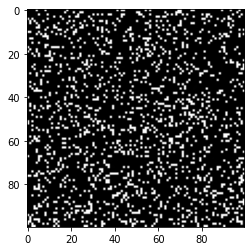

In [4]:
plt.imshow(imageShow[50,...], cmap='gray')

#### Check the results from prediction


In [ ]:
# python predict_single_image.py --image './Data_folder/images/test/image0.nii' --label './Data_folder/labels/test/label0.nii' --result './test_result/predict.nii' --weights './best_metric_model.pth'

import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
import os

image = sitk.ReadImage('./Data_folder_norm/images/test/image0.nii')
imageShow = sitk.GetArrayViewFromImage(image)
label = sitk.ReadImage('./Data_folder_norm/labels/test/label0.nii')
labelShow = sitk.GetArrayViewFromImage(label)
# predict = sitk.ReadImage('./test_result/predict_no_sigmoid.nii')
predict = sitk.ReadImage('./test_result/predict_dice20.nii')
predictShow = sitk.GetArrayViewFromImage(predict)

num_dim = predict.GetDimension()
print(num_dim)

In [ ]:
import numpy as np

NUM = 10

test1 = imageShow[NUM,...]
test2 = labelShow[NUM,...]
test3 = predictShow[NUM,...]

print(np.max(imageShow), np.max(labelShow), np.max(predictShow))
print(test1.dtype,test2.dtype,test3.dtype)

In [ ]:
test3

In [ ]:
NUM = 65

# slice along x
plt.imshow(imageShow[NUM,...], cmap='gray')
plt.figure()
plt.imshow(labelShow[NUM,...], cmap='gray')
plt.figure()
plt.imshow(predictShow[NUM,...], cmap='gray')

In [ ]:
NUM = 50

# slice along the z
plt.imshow(imageShow[...,NUM], cmap='gray')
plt.figure()
plt.imshow(labelShow[...,NUM], cmap='gray')
plt.figure()
plt.imshow(predictShow[...,NUM], cmap='gray')

#### 结果生成gif

In [1]:
# python predict_single_image.py --image './Data_folder/images/test/image0.nii' --label './Data_folder/labels/test/label0.nii' --result './test_result/predict.nii' --weights './best_metric_model.pth'

# load the result
import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
import os

image = sitk.ReadImage('./Data_folder_norm/images/test/image0.nii')
imageShow = sitk.GetArrayViewFromImage(image)/255  # 注意这里要除上255归一化
label = sitk.ReadImage('./Data_folder_norm/labels/test/label0.nii')
labelShow = sitk.GetArrayViewFromImage(label)
# predict = sitk.ReadImage('./test_result/predict_no_sigmoid.nii')
predict = sitk.ReadImage('./test_result/predict_dice20.nii')
predictShow = sitk.GetArrayViewFromImage(predict)

num_dim = predict.GetDimension()
print(num_dim)

3


In [2]:
stack = []
for i in range(imageShow.shape[0]):
    
    temp1 = imageShow[i,...]
    # temp1 = np.interp(imageShow[i,...], (imageShow[i,...].min(), imageShow[i,...].max()), (0, 1))
    temp2 = predictShow[i,...]
    temp3 = labelShow[i,...]
    bar = np.ones((temp1.shape[0], 15))
    # image = np.concatenate((tempImg, bar, tempPred, bar, tempLabel), axis=1)
    image = np.concatenate((temp1, bar, temp2, bar, temp3), axis=1)
    # plt.imshow(image,cmap='gray')
    stack.append(image)
    
stack = np.asarray(stack)

In [3]:
import numpy as np
from PIL import Image

imgs = [Image.fromarray(img*255) for img in stack]  # pil要求乘上255
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save('./test_result/gif/dice20.gif', save_all=True, append_images=imgs[1:], duration=50, loop=0)

#### 检查3D显示的结果

In [ ]:
# veiw the 3D volume 

from skimage import data
import napari

viewer = napari.view_image(data.cells3d(), channel_axis=1, ndisplay=3)

# viewer = napari.view_image(predictShow, channel_axis=1, ndisplay=3)

In [ ]:
# from skimage import data
# import napari

# viewer = napari.view_image(data.cells3d(), channel_axis=1, ndisplay=3)

#### 测试Monai的图片显示

In [ ]:


from monai.visualize import plot_2d_or_3d_image

plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="validation image")

#### 测试neptune ai的记录问题

In [ ]:
import neptune.new as neptune
DOCUMENT = True
TRAIN = 50

In [ ]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/UNet-3D-EM",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet3D_64_vgg16",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {'patchify': 64,
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['config/hyper-parameters'] = PARAMS
    run["sys/tags"].add(["3D_64","vanillar", "50"])


In [ ]:
# Log model, criterion and optimizer name

run["config/model"] = type(model).__name__
run["config/criterion"] = type(criterion).__name__
run["config/optimizer"] = type(optimizer).__name__

In [ ]:
# Log dataset details

run["config/dataset/path"] = data_dir
run["config/dataset/transforms"] = data_tfms
run["config/dataset/size"] = dataset_size
